In [3]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.4.1+cpu
torchvision version: 0.19.1+cpu


In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision
from typing import List
from torch import nn
from PIL import Image
from torchvision import transforms
from torchvision.transforms import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import data_setup, engine
from helper_functions import set_seeds, plot_loss_curves

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
from pathlib import Path
data_path = Path("../data/")
train_dir = data_path / "train"
test_dir = data_path / "test"

In [9]:
train_dir = data_path / "train"
test_dir = data_path / "test"

In [10]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [11]:
BATCH_SIZE = 32 


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x19172b43690>,
 ['freshapples',
  'freshbanana',
  'freshcucumber',
  'freshokra',
  'freshoranges',
  'freshpotato',
  'freshtomato',
  'rottenapples',
  'rottenbanana',
  'rottencucumber',
  'rottenokra',
  'rottenoranges',
  'rottenpotato',
  'rottentomato'])

In [12]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

KeyboardInterrupt: 

(-0.5, 223.5, 223.5, -0.5)

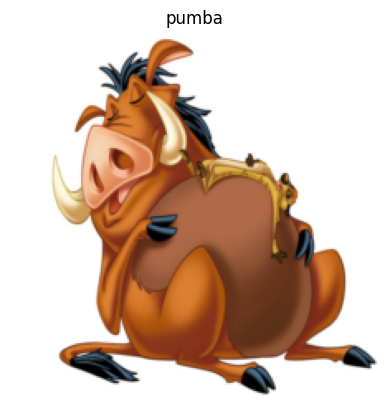

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input image shape: {rand_image_tensor.shape}")
print(f"Output patch embedding shape: {patch_embedding_output.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)

transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
from torchinfo import summary

summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

c:\Users\KSHIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(


Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [1, 196, 768]             7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.60
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.60

In [ ]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer = transformer_encoder_layer,
    num_layers = 12)

transformer_encoder

c:\Users\KSHIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [ ]:
class Vit(nn.Module):
  def __init__(self,
               img_size = 224,
               num_channels=3,
               patch_size=16,
               embedding_dim=768,
               dropout=0.1,
               mlp_size=3072,
               num_transformer_layers=12,
               num_heads=12,
               num_classes=1000):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)


    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                    requires_grad=True)

    num_patches = (img_size*img_size) // patch_size**2
    self.positional_embedding = nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))

    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model = embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True),
                                                     num_layers=num_transformer_layers)

    self.embedding_dropout = nn.Dropout(p=dropout)

    self.mpl_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]

    class_token = self.class_token.expand(batch_size, -1, -1) 

    x = self.patch_embedding(x)

    x = torch.cat((class_token, x), dim=1)

    x = self.positional_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    x = self.mpl_head(x[:, 0]) 

    return x

In [ ]:
demo_img = torch.randn(1,3,224,224)
print(demo_img.shape)
vit = Vit(num_classes=len(class_names))
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[-0.4715,  0.1179, -0.9281, -1.2321,  0.4751,  1.1436]],
       grad_fn=<AddmmBackward0>)

In [ ]:
summary(model=vit,
        input_size=demo_img.shape)

Layer (type:depth-idx)                        Output Shape              Param #
Vit                                           [1, 6]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [40]:
import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.3) 

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0074 | train_acc: 0.1824 | test_loss: 1.8688 | test_acc: 0.1607
Epoch: 2 | train_loss: 1.8339 | train_acc: 0.1703 | test_loss: 1.8837 | test_acc: 0.1607
Epoch: 3 | train_loss: 1.8036 | train_acc: 0.1830 | test_loss: 1.8067 | test_acc: 0.1830
Epoch: 4 | train_loss: 1.7869 | train_acc: 0.1852 | test_loss: 1.8282 | test_acc: 0.1540
Epoch: 5 | train_loss: 1.7854 | train_acc: 0.1824 | test_loss: 1.8077 | test_acc: 0.1607
Epoch: 6 | train_loss: 1.7828 | train_acc: 0.1996 | test_loss: 1.7992 | test_acc: 0.1607
Epoch: 7 | train_loss: 1.7848 | train_acc: 0.2016 | test_loss: 1.7988 | test_acc: 0.1607
Epoch: 8 | train_loss: nan | train_acc: 0.1979 | test_loss: nan | test_acc: 0.1562
Epoch: 9 | train_loss: nan | train_acc: 0.1439 | test_loss: nan | test_acc: 0.1562
Epoch: 10 | train_loss: nan | train_acc: 0.1458 | test_loss: nan | test_acc: 0.1562


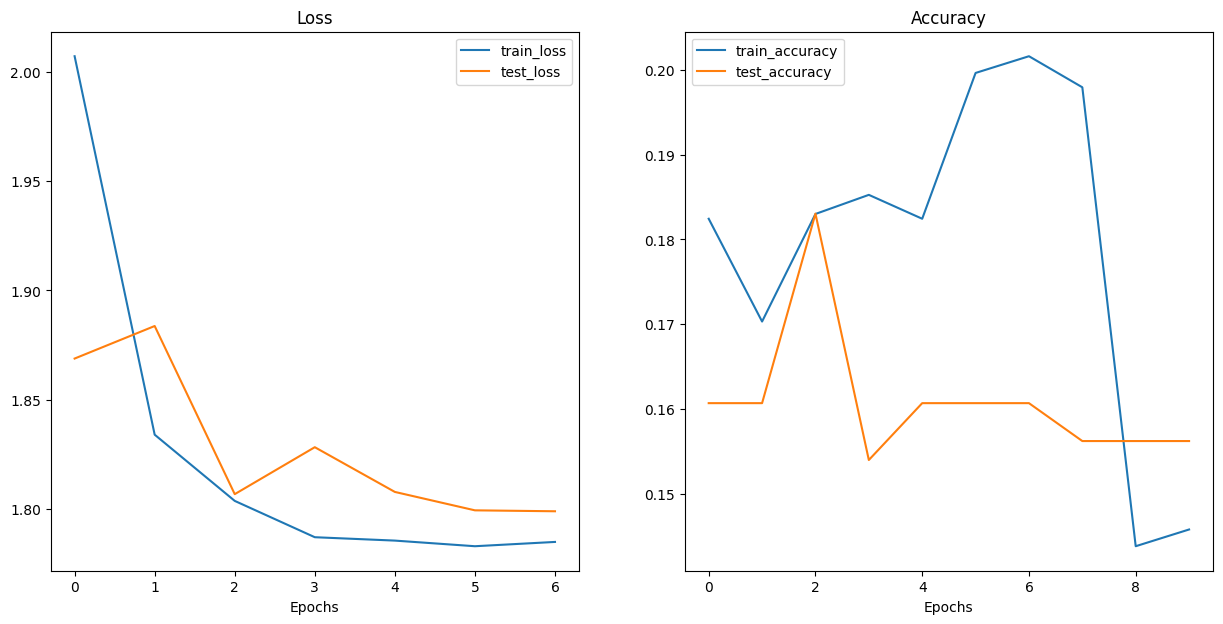

In [41]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [22]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [29]:
from pathlib import Path
data_path = Path("../data/")
image_path = data_path / "cartoon"
train_dir = image_path / "train"
test_dir = image_path / "test"

In [30]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('../data/cartoon/train'), WindowsPath('../data/cartoon/test'))

In [31]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [32]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) 


In [48]:
import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5773 | train_acc: 0.8626 | test_loss: 0.1731 | test_acc: 0.9799
Epoch: 2 | train_loss: 0.2002 | train_acc: 0.9611 | test_loss: 0.1054 | test_acc: 0.9844
Epoch: 3 | train_loss: 0.1354 | train_acc: 0.9738 | test_loss: 0.0810 | test_acc: 0.9799
Epoch: 4 | train_loss: 0.1029 | train_acc: 0.9820 | test_loss: 0.0662 | test_acc: 0.9821
Epoch: 5 | train_loss: 0.0823 | train_acc: 0.9879 | test_loss: 0.0571 | test_acc: 0.9866
Epoch: 6 | train_loss: 0.0690 | train_acc: 0.9910 | test_loss: 0.0541 | test_acc: 0.9844
Epoch: 7 | train_loss: 0.0581 | train_acc: 0.9930 | test_loss: 0.0497 | test_acc: 0.9866
Epoch: 8 | train_loss: 0.0495 | train_acc: 0.9944 | test_loss: 0.0439 | test_acc: 0.9866
Epoch: 9 | train_loss: 0.0429 | train_acc: 0.9958 | test_loss: 0.0412 | test_acc: 0.9888
Epoch: 10 | train_loss: 0.0372 | train_acc: 0.9972 | test_loss: 0.0397 | test_acc: 0.9866


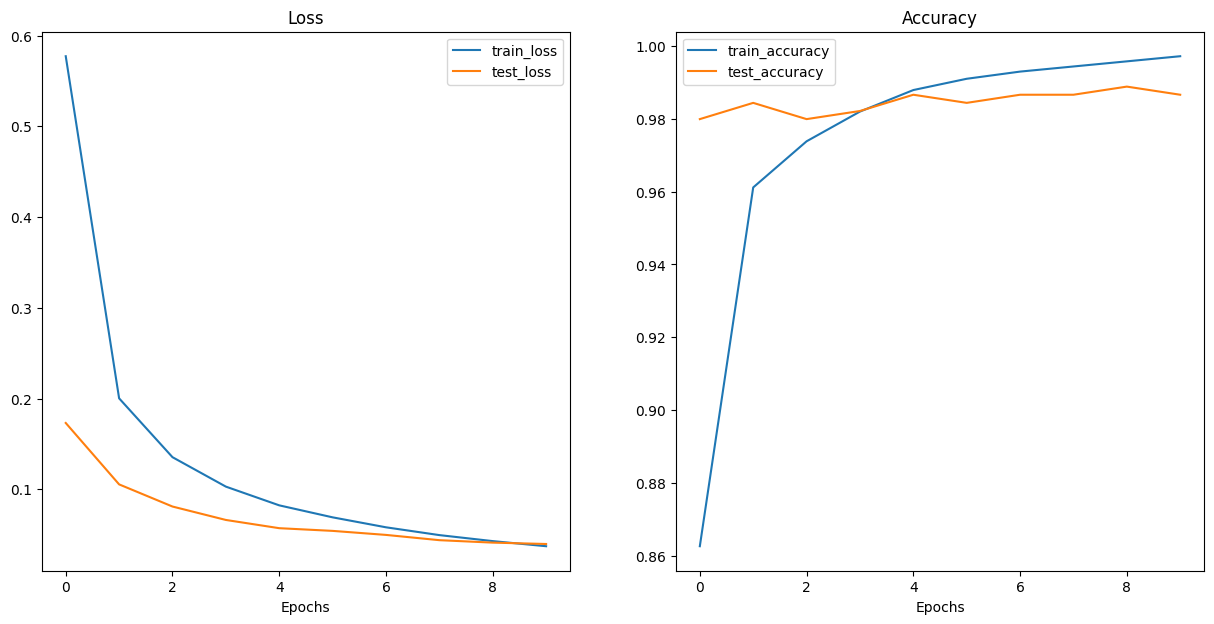

In [49]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [33]:
def pred_and_plot_img(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    resize_transform = transforms.Resize((224, 224))

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = resize_transform(target_image)

    target_image = target_image / 255.0

    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)

        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


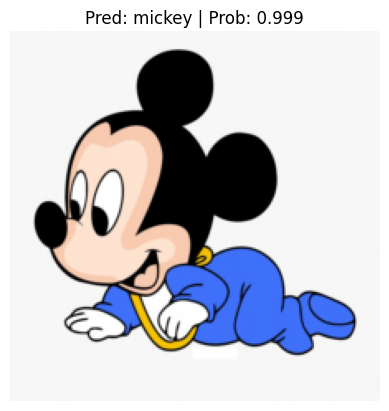

In [72]:
custom_image_path = '../data/cartoon/test/mickey/0-4256_baby-clipart-disney-baby-mickey-mouse-transparent-background.jpg'
pred_and_plot_img(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [73]:
import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor.pth")

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor.pth


In [34]:
from pathlib import Path

pretrained_vit_model_size = Path("../models/08_pretrained_vit_feature_extractor.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

import matplotlib.pyplot as plt
import torch
import torchvision
from typing import List
from torch import nn
from PIL import Image
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import data_setup, engine
from helper_functions import set_seeds, plot_loss_curves

device = "cuda" if torch.cuda.is_available() else "cpu"
device

from pathlib import Path
data_path = Path("../data/")
image_path = data_path / "cartoon"
train_dir = image_path / "train"
test_dir = image_path / "test"

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

BATCH_SIZE = 32 

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

class Vit(nn.Module):
    def __init__(self,
                 img_size=224,
                 num_channels=3,
                 patch_size=16,
                 embedding_dim=768,
                 dropout=0.1,
                 mlp_size=3072,
                 num_transformer_layers=12,
                 num_heads=12,
                 num_classes=1000):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

        num_patches = (img_size * img_size) // patch_size ** 2
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                  nhead=num_heads,
                                                                                                  dim_feedforward=mlp_size,
                                                                                                  activation="gelu",
                                                                                                  batch_first=True,
                                                                                                  norm_first=True),
                                                         num_layers=num_transformer_layers)

        self.embedding_dropout = nn.Dropout(p=dropout)

        self.mpl_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_token.expand(batch_size, -1, -1)  

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.positional_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.mpl_head(x[:, 0])  

        return x

def load_model(model_path, num_classes):
    model = torchvision.models.vit_b_16()
    model.heads = nn.Linear(in_features=768, out_features=num_classes)
    model.load_state_dict(torch.load(model_path))
    return model

pretrained_vit = load_model("../models/08_pretrained_vit_feature_extractor.pth", num_classes=len(class_names)).to(device)

def pred_and_plot_img(model: torch.nn.Module,
                      image_path: str,
                      class_names: List[str],
                      transform=None,
                      device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str]): list of class names for target image.
        transform (_type_, optional): transform for target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.
    """
    resize_transform = transforms.Resize((224, 224))

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = resize_transform(target_image)

    target_image = target_image / 255.0

    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)

        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)
    plt.show()

torch version: 2.2.1+cu118
torchvision version: 0.17.1+cpu
Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


c:\Users\KSHIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


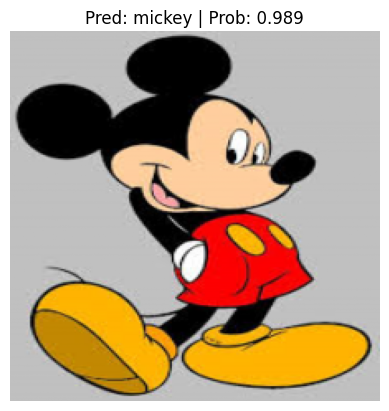

In [2]:
specific_image_path = "../data/cartoon/mickey.jpeg"
pred_and_plot_img(model=pretrained_vit,
                  image_path=specific_image_path,
                  class_names=class_names)


In [3]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

# Define paths
paths = {
    "models": "../models",
    "data": "../data/cartoon",
    "output": "../output"
}

MODEL_NAME_PREFIX = "cnn_disney_1719493114"

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the object detection model
object_detection_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
object_detection_model.to(device)
object_detection_model.eval()

def detect_objects(image_path, model, device):
    try:
        image = Image.open(image_path).convert("RGB")
        transform = transforms.Compose([transforms.ToTensor()])
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            detections = model(image_tensor)[0]
        
        return image, detections
    except RuntimeError as e:
        print(f"CUDA error: {e}")
        print("Retrying on CPU...")
        device = "cpu"
        model.to(device)
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            detections = model(image_tensor)[0]
        
        return image, detections
    except NotImplementedError as e:
        print(f"Error: {e}")
        print("This model might not be supported or correctly implemented.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None

def process_and_save(image, detections):
    draw = ImageDraw.Draw(image)
    if not os.path.exists(paths["output"]):
        os.makedirs(paths["output"])

    for idx, box in enumerate(detections['boxes']):
        score = detections['scores'][idx].item()
        if score > 0.5:
            box = box.to(torch.int64).tolist()
            draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=3)

            cropped_image = image.crop((box[0], box[1], box[2], box[3]))
            cropped_image.save(f"{paths['output']}/detected_object_{idx}.png")

    return image

image_path = "../data/cartoon/image.png"  
image, detections = detect_objects(image_path, object_detection_model, device)

if detections:
    annotated_image = process_and_save(image.copy(), detections)
    annotated_image.show()  
    annotated_image.save(f"{paths['output']}/annotated_image.png")
else:
    print("No detections found or an error occurred.")


c:\Users\KSHIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KSHIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CUDA error: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cp

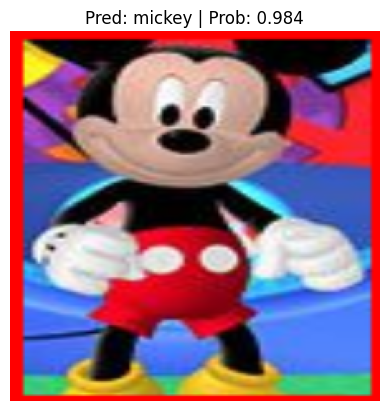

In [4]:
specific_image_path = "../output/detected_object_0.png"
pred_and_plot_img(model=pretrained_vit,
                  image_path=specific_image_path,
                  class_names=class_names)